In [ ]:
# Download the dataset
from google.colab import files
files.upload()
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d wanderdust/skin-lesion-analysis-toward-melanoma-detection

Saving kaggle.json to kaggle.json
100% 11.3G/11.3G [01:57<00:00, 171MB/s]
100% 11.3G/11.3G [01:57<00:00, 104MB/s]


In [ ]:
# Unzip the dataset
from zipfile import ZipFile

with ZipFile("/content/skin-lesion-analysis-toward-melanoma-detection.zip","r") as dataset:
  dataset.extractall()

In [ ]:
# Identify th files in the dataset
import os
dataset_files={

    # Train Data
    "train_data_melomina":[i for i in os.walk("/content/skin-lesions/train/melanoma")][0][2],
    "train_data_nevus":[i for i in os.walk("/content/skin-lesions/train/nevus")][0][2],
    "train_data_seborrheic_keratosis":[i for i in os.walk("/content/skin-lesions/train/seborrheic_keratosis")][0][2],
    # Test Data
    "test_data_melomina":[i for i in os.walk("/content/skin-lesions/test/melanoma")][0][2],
    "test_data_nevus":[i for i in os.walk("/content/skin-lesions/test/nevus")][0][2],
    "test_data_seborrheic_keratosis":[i for i in os.walk("/content/skin-lesions/test/seborrheic_keratosis")][0][2],
    # Validation Data
    "val_data_melomina":[i for i in os.walk("/content/skin-lesions/valid/melanoma")][0][2],
    "val_data_nevus":[i for i in os.walk("/content/skin-lesions/valid/nevus")][0][2],
    "val_data_seborrheic_keratosis":[i for i in os.walk("/content/skin-lesions/valid/seborrheic_keratosis")][0][2]

}


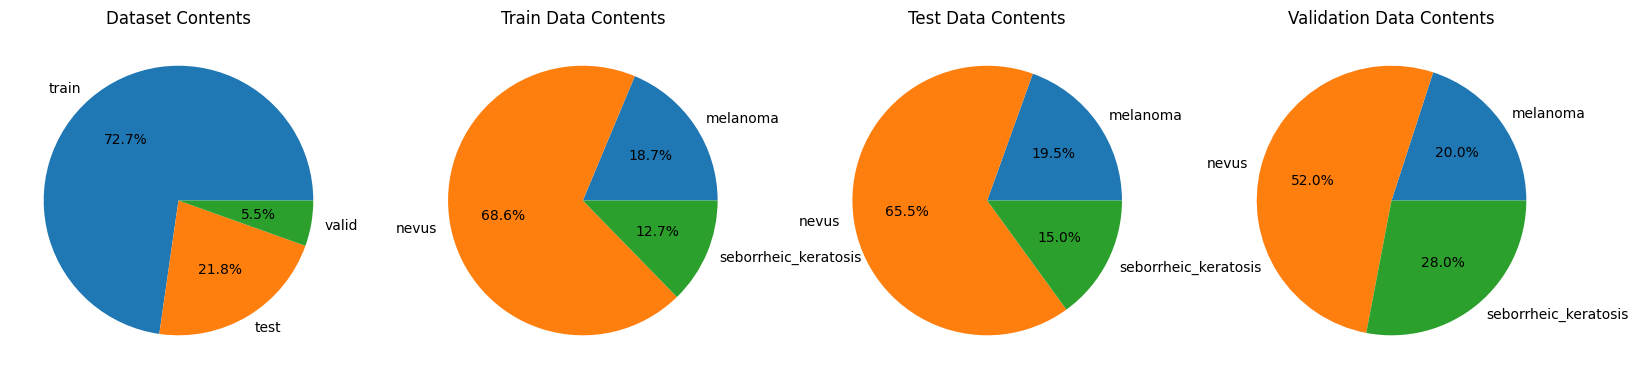

In [ ]:
# Visualize the contents
import matplotlib.pyplot

labels=["melanoma","nevus","seborrheic_keratosis"]
datatypes=["train","test","valid"]

fig,ax = matplotlib.pyplot.subplots(1,4,figsize=(20,6))

ax[0].pie([len(dataset_files["train_data_melomina"])+len(dataset_files["train_data_nevus"])+len(dataset_files["train_data_seborrheic_keratosis"]),len(dataset_files["test_data_melomina"])+len(dataset_files["test_data_nevus"])+len(dataset_files["test_data_seborrheic_keratosis"]),len(dataset_files["val_data_melomina"])+len(dataset_files["val_data_nevus"])+len(dataset_files["val_data_seborrheic_keratosis"])],labels=datatypes,autopct='%1.1f%%')
ax[0].set_title("Dataset Contents")
ax[1].pie([len(dataset_files["train_data_melomina"]),len(dataset_files["train_data_nevus"]),len(dataset_files["train_data_seborrheic_keratosis"])],labels=labels,autopct='%1.1f%%')
ax[1].set_title("Train Data Contents")
ax[2].pie([len(dataset_files["test_data_melomina"]),len(dataset_files["test_data_nevus"]),len(dataset_files["test_data_seborrheic_keratosis"])],labels=labels,autopct='%1.1f%%')
ax[2].set_title("Test Data Contents")
ax[3].pie([len(dataset_files["val_data_melomina"]),len(dataset_files["val_data_nevus"]),len(dataset_files["val_data_seborrheic_keratosis"])],labels=labels,autopct='%1.1f%%')
ax[3].set_title("Validation Data Contents")
matplotlib.pyplot.show()

In [ ]:
# Visualize random images
import numpy
from PIL import Image
import random

def random_image_selector():
  random_label=random.choice(labels)
  random_datatype=random.choice(datatypes)
  random_image=random.choice([i for i in os.walk(f"/content/skin-lesions/{random_datatype}/{random_label}")][0][2])
  img=numpy.asarray(Image.open(f"/content/skin-lesions/{random_datatype}/{random_label}/{random_image}"))
  return img,random_label,random_datatype


def display_images_by_value(ncols=3,nrows=3):
  fig,ax=matplotlib.pyplot.subplots(nrows=nrows,ncols=ncols,figsize=(20,12))
  for i in range(ncols):
    for j in range(nrows):
      img,random_label,random_datatype=random_image_selector()
      ax[i][j].imshow(img)
      ax[i][j].set_title(f"{random_datatype}: {random_label}")
      ax[i][j].axis("off")

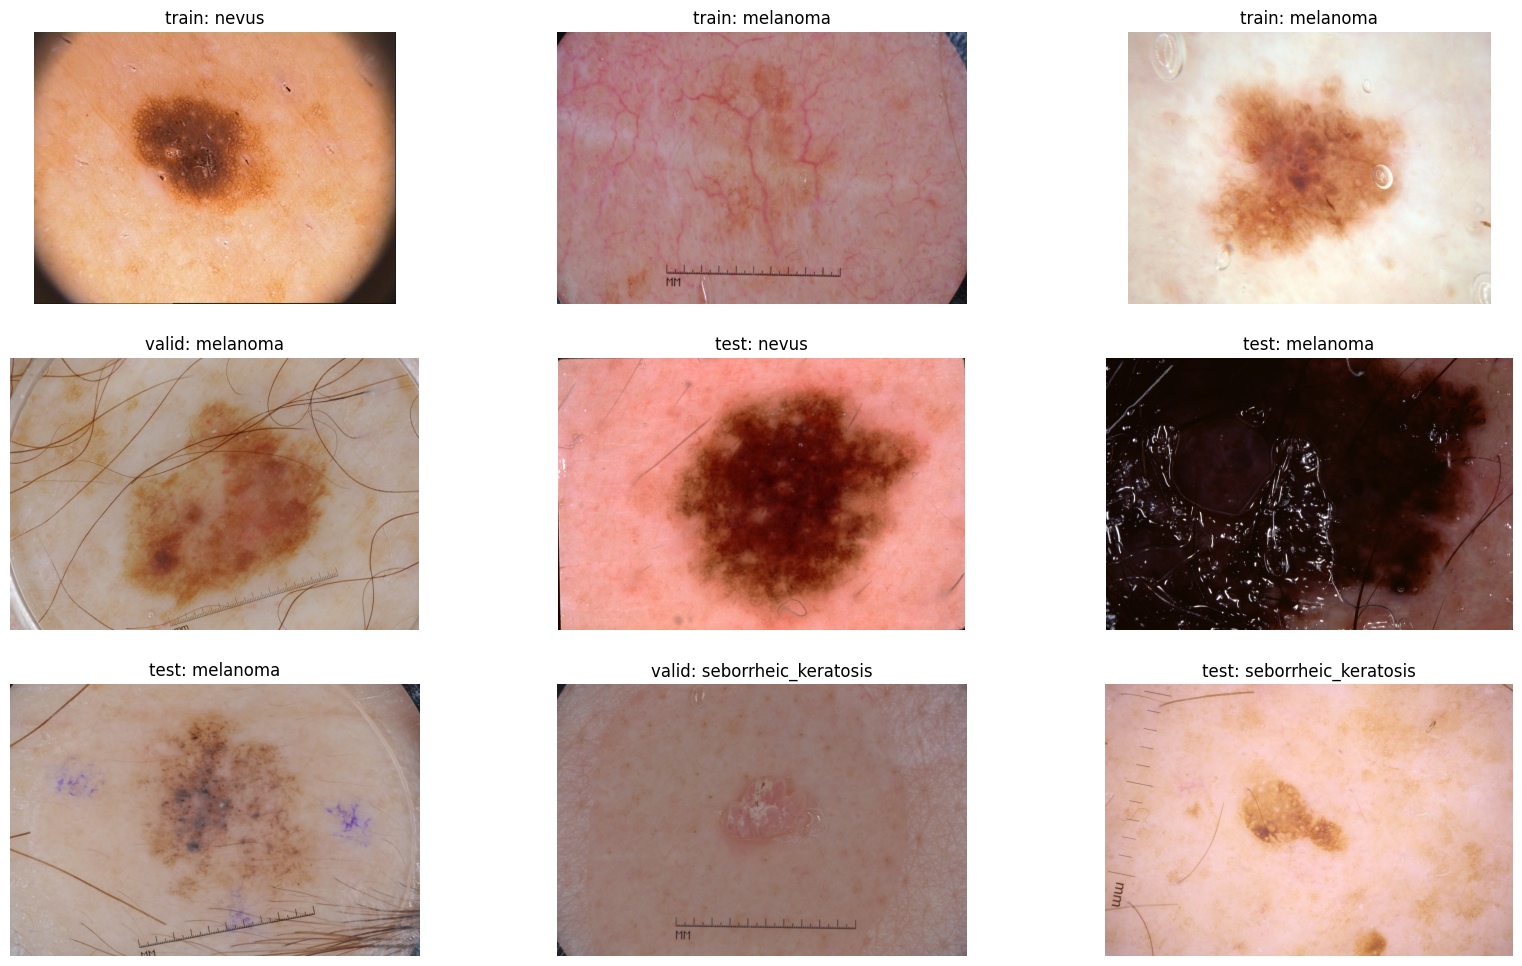

In [ ]:
display_images_by_value(3,3)

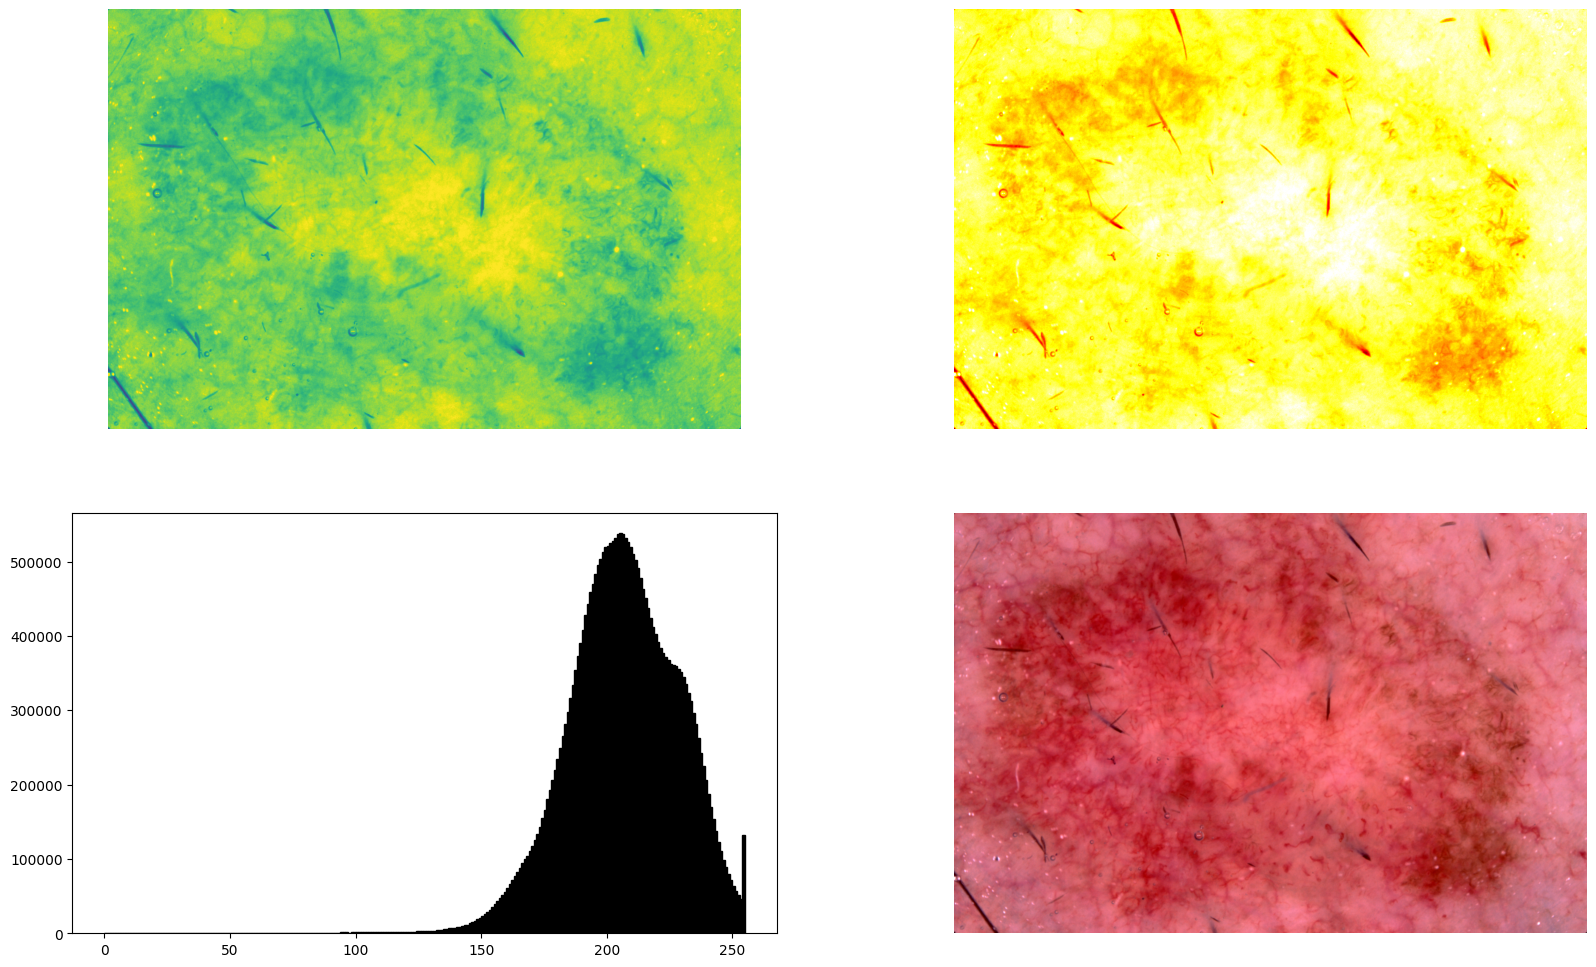

In [ ]:
img,random_label,random_datatype=random_image_selector()

fig,ax=matplotlib.pyplot.subplots(2,2,figsize=(20,12))
lum_img=img[:,:,0]
ax[0][0].imshow(lum_img)
ax[0][0].axis('off')
ax[0][1].imshow(lum_img,cmap='hot')
ax[0][1].axis('off')
ax[1][0].hist(lum_img.ravel(), bins=range(256), fc='k', ec='k')
ax[1][1].imshow(img, interpolation="bilinear")
ax[1][1].axis('off')
matplotlib.pyplot.show()

In [ ]:
# Preprocess Images
import tensorflow
import tensorflow_datasets

train_data_dir="/content/skin-lesions/train"
test_data_dir="/content/skin-lesions/test"
batch_size = 32
img_height = 180
img_width = 180

train_ds = tensorflow.keras.utils.image_dataset_from_directory(
  train_data_dir,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2000 files belonging to 3 classes.
Using 1600 files for training.


In [ ]:
val_ds = tensorflow.keras.utils.image_dataset_from_directory(
  test_data_dir,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 600 files belonging to 3 classes.
Using 120 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['melanoma', 'nevus', 'seborrheic_keratosis']


In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
normalization_layer = tensorflow.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(numpy.min(first_image), numpy.max(first_image))

0.03274596 0.89682335


In [ ]:
AUTOTUNE = tensorflow.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
num_classes = 3

model = tensorflow.keras.Sequential([
  tensorflow.keras.layers.Rescaling(1./255),
  tensorflow.keras.layers.Conv2D(32, 3, activation='relu'),
  tensorflow.keras.layers.MaxPooling2D(),
  tensorflow.keras.layers.Conv2D(32, 3, activation='relu'),
  tensorflow.keras.layers.MaxPooling2D(),
  tensorflow.keras.layers.Conv2D(32, 3, activation='relu'),
  tensorflow.keras.layers.MaxPooling2D(),
  tensorflow.keras.layers.Flatten(),
  tensorflow.keras.layers.Dense(128, activation='relu'),
  tensorflow.keras.layers.Dense(num_classes)
])

model.compile(
  optimizer='adam',
  loss=tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5
)

Epoch 1/5
50/50 [==============================] - 256s 5s/step - loss: 0.8628 - accuracy: 0.6725 - val_loss: 0.8613 - val_accuracy: 0.6667
Epoch 2/5
50/50 [==============================] - 73s 1s/step - loss: 0.8044 - accuracy: 0.6787 - val_loss: 0.7679 - val_accuracy: 0.6667
Epoch 3/5
50/50 [==============================] - 72s 1s/step - loss: 0.7692 - accuracy: 0.6844 - val_loss: 0.7705 - val_accuracy: 0.6750
Epoch 4/5
50/50 [==============================] - 72s 1s/step - loss: 0.7430 - accuracy: 0.6875 - val_loss: 0.7506 - val_accuracy: 0.6833
Epoch 5/5
50/50 [==============================] - 74s 1s/step - loss: 0.7288 - accuracy: 0.6919 - val_loss: 0.7567 - val_accuracy: 0.6667
